In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import math
from scipy.optimize import curve_fit

In [2]:
Filename = '080607.fits' #'140423A.fits'
hdulist = fits.open(Filename) #hdulist = fits.open('141028A_gemini.fits') #hdulist = fits.open('140311A.fits')

In [3]:
Flux = hdulist[0]
Error = hdulist[1]
Wavelength = hdulist[2]

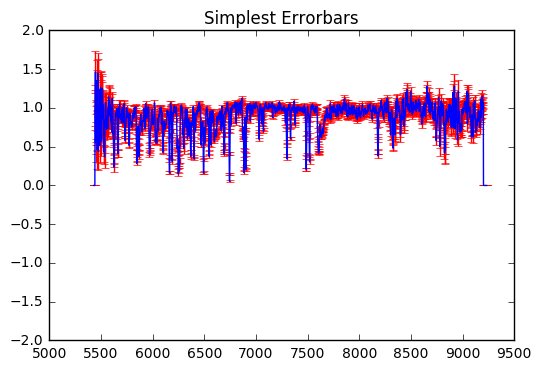

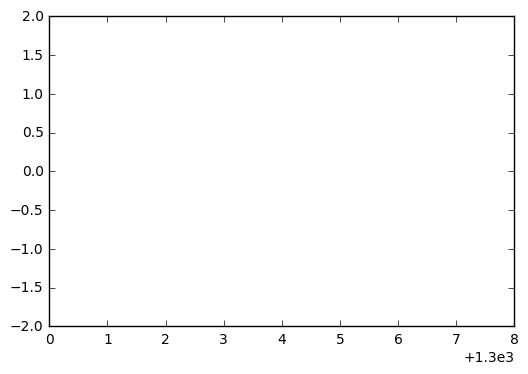

In [4]:
plt.figure()
plt.errorbar(Wavelength.data, Flux.data, yerr= Error.data, ecolor='r')
plt.title("Simplest Errorbars")
axes = plt.gca()
axes.set_ylim([-2,2])
#axes.set_xlim([8000,8500])
plt.show()

redshift = 3.036 #3.258 #redshift = 2.332 #redshift = 4.953
Wavelength_rest = np.array(Wavelength.data/(1+redshift))
Flux_norm = np.array(Flux.data)
Error_norm = np.array(Error.data)

#Sample plot for check
plt.figure()
plt.errorbar(Wavelength_rest, Flux_norm)
#plt.title("Simplest Errorbars")
axes = plt.gca()
axes.set_ylim([-2,2])
axes.set_xlim([1300,1308])
plt.show()

In [ ]:
print Wavelength_rest

In [5]:
#For GMOS we will take +/-1000km/s around the center of the line to make Fox et al Plot
f = open('line_list.dat', 'r')

delta_v = 1000.0;
c = 300000.0;
line_name = []
line_lam = []
delta_lam = []
line_num = 0

# Getting wavelengths and names of the important files
for line in f.readlines():
    row = line.strip()
    columns = row.split()
    line_lam.append(float(columns[0]))
    line_name.append(columns[1]+columns[2])
    delta_lam.append(delta_v*float(columns[0])/c) # delta_lambda = lambda*(delta_v)/c
    #print (delta_v*float(columns[0])/c)
    line_num = line_num + 1

f.close()
line_wavelength = np.array(line_lam)
delta_lambda = np.array(delta_lam)
#print line_num

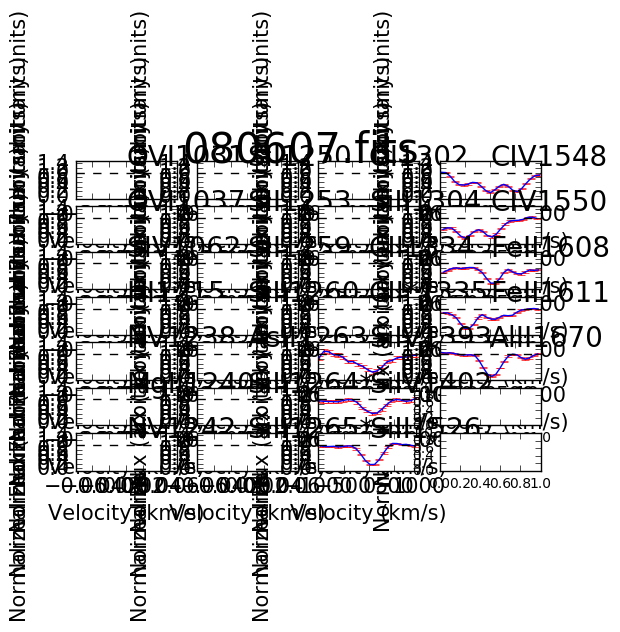

In [6]:
Wavelength_box = []
Velocity_box = []
Flux_box = []
Error_box = []

ncols = 4
nrows = int(math.ceil(float(line_num)/ncols))
f, axarr = plt.subplots(nrows, ncols)
plt.suptitle(Filename, fontsize = 30)

for i in range(0,line_num):
    Wavelength_window = Wavelength_rest[(Wavelength_rest >= (line_wavelength[i]-delta_lambda[i])) * (Wavelength_rest <= (line_wavelength[i]+delta_lambda[i]))]
    Velocity_window = ((Wavelength_window - line_wavelength[i])*c)/line_wavelength[i]
    Flux_window = Flux_norm[(Wavelength_rest >= (line_wavelength[i]-delta_lambda[i])) * (Wavelength_rest <= (line_wavelength[i]+delta_lambda[i]))]
    Error_window = Error_norm[(Wavelength_rest >= (line_wavelength[i]-delta_lambda[i])) * (Wavelength_rest <= (line_wavelength[i]+delta_lambda[i]))]
    
    Wavelength_box.append(Wavelength_window)
    Velocity_box.append(Velocity_window)
    Flux_box.append(Flux_window)
    Error_box.append(Error_window)
    
    rownum = int(i%nrows)
    colnum = int(i//nrows)
    axarr[rownum, colnum].errorbar(Velocity_window, Flux_window, yerr=Error_window, ecolor='r')
    axarr[rownum, colnum].set_ylim(-0.1, 1.5)
    axarr[rownum, colnum].text(0, 1.3, line_name[i], fontsize=20)
    axarr[rownum, colnum].set_xlabel('Velocity (km/s)', fontsize=15)
    axarr[rownum, colnum].set_ylabel('Normalized Flux (arbitrary units)', fontsize=15)
    axarr[rownum, colnum].axhline(y=1, color='k', ls='dashed')
    axarr[rownum, colnum].tick_params(axis='x', labelsize=15)
    axarr[rownum, colnum].tick_params(axis='y', labelsize=15)

plt.show()

In [ ]:
# Make a list of line-windows where you want to do Gaussian fits
# and enter the number of components you want to fit
# and the range of velocities over which you want to fit those components (basically the domain of the fit)
list_line_windows       = [12, 16]
list_component_num_fit  = [2, 3]
list_velocity_range_neg = [-300, -500]          #-ve end of the fit windows
list_velocity_range_pos = [500, 500]          # +ve end of the fit windows
list_line_width_guess   = [[100,100], [100,100,100]]            # 100 km/s width guess 
list_line_amp_guess     = [[1,0.5], [1,1,1]]                # amplitude guess = 1
list_line_center_guess  = [[-100, 250], [-20,50,200]]

num_windows = len(list_line_windows)


def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    y = 1-y
    return y

guess = []                     #guess = [0, 60000, 80, 1000, 60000, 80]
for i in range(num_windows):
    for j in range(list_component_num_fit[i]):
        guess.append(list_line_center_guess[i][j])
        guess.append(list_line_amp_guess[i][j])
        guess.append(list_line_width_guess[i][j])
    
    x = Velocity_box[list_line_windows[i]-1]
    y = Flux_box[list_line_windows[i]-1]
    error = Error_box[list_line_windows[i]-1]
    x_fit_window = x[(x>list_velocity_range_neg[i])*(x<list_velocity_range_pos[i])]
    y_fit_window = y[(x>list_velocity_range_neg[i])*(x<list_velocity_range_pos[i])]
    error_fit_window = error[(x>list_velocity_range_neg[i])*(x<list_velocity_range_pos[i])]
    
    #Check this!!! popt, pcov = curve_fit(func, x, y, p0=guess, sigma=error, absolute_sigma=True)
    popt, pcov = curve_fit(func, x_fit_window, y_fit_window, p0=guess, sigma=error_fit_window)
    print(popt)
    print(pcov)
    fit = func(x, *popt)
    
    plt.errorbar(x,y,error, ecolor='r')
    plt.title(Filename + "  " + line_name[list_line_windows[i]-1])
    plt.xlabel('Velocity (km/s)', fontsize=15)
    plt.ylabel('Normalized Flux', fontsize=15)
    plt.plot(x, fit , 'g-')
    plt.show()
    guess[:] = []